# **Mount the Drive and change the working directory:**

In [85]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/My Drive/MSC Thesis

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/MSC Thesis'
/content/gdrive/My Drive/MSC Thesis


# Import Required Modules

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import sklearn
from sklearn.feature_selection import mutual_info_regression

predictors = pd.read_csv('pred_inputs.csv')
predict_these = np.unique(predictors['INSTRUMENT'])

# Functions for preprocessing and Feature Generation

In [0]:
def from_csv(instrument):
    df = pd.read_csv('Data/' + instrument + '.csv')
    df['date'] = pd.to_datetime(df['date']).dt.date
    df.set_index('date',inplace=True)
    df = df.sort_values(by = 'date')
    df.columns = [instrument]
    return df
  
def preprocessing(commodity):
    #####################################################################################
    # This ensures chronological order (some time series are NOT in order)              #
    #####################################################################################
    
    prices_df = db.get_instrument_data(commodity)
    prices_df = prices_df.sort_values(by = 'date')
    prices_df.columns = [commodity]
    return prices_df
  
def get_predictors(commodity, predictors):
    ####################################################################
    # This returns the df containing the values of the commodity to be #
    # predicted as well as that of its predictors.                     #
    #                                                                  #
    # Args:                                                            #
    # 1) commodity: name of the commodity                              #
    # 2) predictors: the dataframe sent by Michael Button              #
    ####################################################################
    
    # get a list of all its predictors
    Pred = list(predictors.loc[predictors['INSTRUMENT'] == commodity]['INPUT'])
    Pred = [p for p in Pred if p != commodity]
    
    # Initialize the dataframe with the commodity we want to predict
    DF = from_csv( commodity )
    
    # Keep adding the predictors
    for predictor in Pred:
        temp_df = from_csv( predictor )
        DF = DF.join(temp_df)
    return DF
  
def price_to_returns(prices_df, diff):
    ###############################################################
    # This changes the price data to 5 day log difference.        #
    # If X has negative values, use the following scheme:         # 
    #          X := X - min(X) + 1                                #
    ###############################################################
    
    # forward fill
    prices_df.fillna(method='ffill', inplace = True)
    
    returns_df = prices_df.copy()
    for colname in prices_df.columns:
        temp = prices_df.loc[:,colname]
        
        if np.min(temp) <= 0:
            temp = temp - np.min(temp) + 1
        returns_df[colname] = np.log(temp) - np.log(temp.shift(diff))

    # drop rows with NaN
    returns_df.dropna(inplace = True)
    return returns_df
  
    
def feature_generation(metal, time_pred = [1,5,22]):
  metal = metal + '_lme_prices'
  Metal_DF = get_predictors(metal, predictors)
  # remove comex, since comex is not 
  Metal_DF = Metal_DF[[col for col in list(Metal_DF.columns) if 'comex' not in col]]
  
  # 1, 5, 22 days
  # log difference L
  LD = [price_to_returns(Metal_DF, t_pred) for t_pred in time_pred]

  # EWMA of L
  # EWMA = [L.ewm(span = horizon).mean() for horizon, L in zip(time_pred, LD)]
  EWMA = [LD[0].ewm(halflife = horizon).mean() for horizon in time_pred ]

  # EWMV of L
  # 1. calculate expanding window mean for the returns (1 day) 
  # 2. subtract rolling mean and take square
  EM = LD[0].expanding(2).mean() 
  EWMV = [((LD[0] - EM)**2).ewm(span = horizon).mean()**0.5 for horizon in time_pred ]
  
  # rename columns
  for horizon, ld, ewma, ewmv in zip(time_pred, LD, EWMA, EWMV):
    ld.columns = [col + '_LD_' + str(horizon) for col in ld.columns]
    ewma.columns = [col + '_EWMA_' + str(horizon) for col in ewma.columns]
    ewmv.columns = [col + '_EWMV_' + str(horizon) for col in ewmv.columns]
    
  # merge together 
  ALL_FEATURES = pd.concat([pd.concat(DFS, axis = 1, sort=True) for DFS in [LD, EWMA, EWMV]], axis = 1)
  ALL_FEATURES_columns = list(ALL_FEATURES.columns)
  ALL_FEATURES_columns.sort()
  ALL_FEATURES = ALL_FEATURES.loc[:,ALL_FEATURES_columns]
  ALL_FEATURES.dropna(inplace = True)
  
  return ALL_FEATURES



def feature_extraction(DF, column_name, lag):
  # This extracts the relevant predictors for the column_name
  # threshold is the % of predictors that we want to include
  # Mutual Information
  DF_metal = DF.loc[:,[column_name]]
  MI_table = np.zeros(DF.shape[1])
  for i in range(DF.shape[1]):
      MI = sklearn.feature_selection.mutual_info_regression(DF_metal, DF.iloc[:,i])
      MI_table[i] = MI
  
  tol = 1e-3
  MI_table_2 = MI_table[MI_table > tol]
  out, bins = pd.qcut(MI_table_2, [0.9, 1], retbins=True)
  selected_cols = list(MI_table > bins[-2])
  
  DF = DF.loc[:,selected_cols].shift(periods = lag)
  DF.columns = [col + '_lag' for col in DF.columns]
  DF = pd.concat([DF_metal, DF], axis = 1, sort = True).dropna()
  time_column = pd.DataFrame(index = DF.index, 
                             data = np.arange(DF.shape[0])*0.01 , 
                             columns = ['time'] )
  DF = pd.concat([DF, time_column], axis = 1)
  # add time column
  
  
  return(DF)


In [0]:
DF = feature_generation('al', time_pred = [1,5,22])
DF = feature_extraction(DF, 'al_lme_prices_LD_1', 1)

# Plot the prices 

In [0]:
AL = get_predictors('al_lme_prices', predictors).iloc[:,0]
CU = get_predictors('cu_lme_prices', predictors).iloc[:,0]

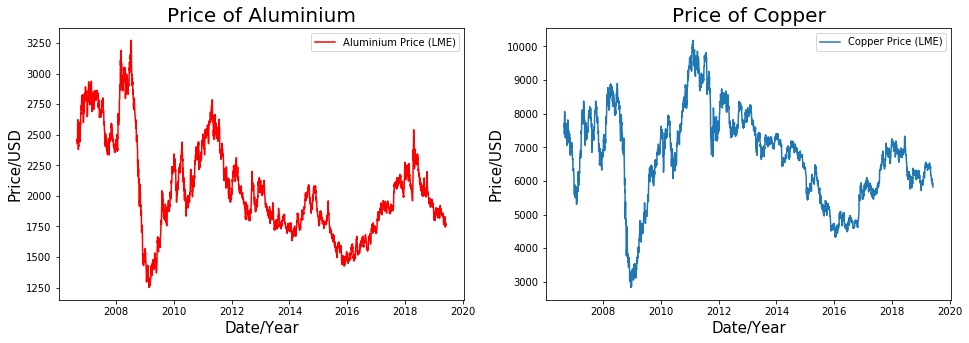

In [90]:
fig, ax = plt.subplots(1, 2)


fig.set_figheight(5)
fig.set_figwidth(16)

plt.subplot(1, 2, 1)
plt.plot(AL, label = 'Aluminium Price (LME)', color = 'red')
plt.title('Price of Aluminium', fontsize = 20)
plt.legend()
plt.xlabel('Date/Year', fontsize = 15)
plt.ylabel('Price/USD', fontsize = 15)

plt.subplot(1, 2, 2)
plt.plot(CU, label = 'Copper Price (LME)')
plt.title('Price of Copper', fontsize = 20)
plt.xlabel('Date/Year', fontsize = 15)
plt.ylabel('Price/USD', fontsize = 15)
plt.legend()

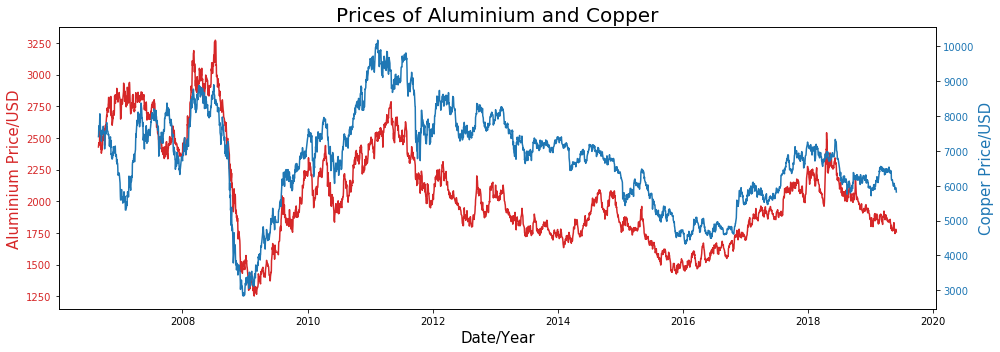

In [91]:
# Create some mock data


fig, ax1 = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(14)

color = 'tab:red'
ax1.set_title('Prices of Aluminium and Copper', fontsize = 20)

ax1.set_xlabel('Date/Year', fontsize = 15)
ax1.set_ylabel('Aluminium Price/USD', color=color, fontsize = 15)
ax1.plot(AL, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Copper Price/USD', color=color, fontsize = 15)  # we already handled the x-label with ax1
ax2.plot(CU, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [92]:
print("Stats for Aluminium")
print('mean:', ((AL - AL.shift(1) )/ AL.shift(1) )[1:].mean() )
print('std:', ((AL - AL.shift(1) )/ AL.shift(1) )[1:].std() )
print('skew:', ((AL - AL.shift(1) )/ AL.shift(1) )[1:].skew() )
print('kurtosis:', ((AL - AL.shift(1) )/ AL.shift(1) )[1:].kurtosis() )

print(' ')

print("Stats for Copper")
print('mean:', ((CU - CU.shift(1) )/ CU.shift(1) )[1:].mean() )
print('std:', ((CU - CU.shift(1) )/ CU.shift(1) )[1:].std() )
print('skew:', ((CU - CU.shift(1) )/ CU.shift(1) )[1:].skew() )
print('kurtosis:', ((CU - CU.shift(1) )/ CU.shift(1) )[1:].kurtosis() )



Stats for Aluminium
mean: 1.0504950464966637e-06
std: 0.014273448703172027
skew: 0.032615605476514965
kurtosis: 1.9703354173871528
 
Stats for Copper
mean: 7.519133252614093e-05
std: 0.017346632577538504
skew: 0.06686466321070215
kurtosis: 3.7186520643142176


In [93]:
AL_returns = ((AL - AL.shift(1) )/ AL.shift(1) )[1:]
CU_returns = ((CU - CU.shift(1) )/ CU.shift(1) )[1:]

np.cov(AL_returns, CU_returns)

array([[2.03731338e-04, 4.14980990e-05],
       [4.14980990e-05, 3.00905662e-04]])

In [97]:
pd.rolling() AL_returns

SyntaxError: ignored